# Spatial index - How to boost spatial queries?

While using the technique from previous examples produces correct results, it is in fact quite slow from performance point of view. Especially when having large datasets (quite typical nowadays), the point in polygon queries can become frustratingly slow, which can be a nerve-racking experience for a busy geo-data scientist. 

Luckily there is an easy and widely used solution called **spatial index** that can significantly boost the performance of your spatial queries. Various alternative techniques has been developed to boost spatial queries, but one of the most popular one and widely used is a spatial index based on [R-tree](https://en.wikipedia.org/wiki/R-tree) data structure. 

The core idea behind the **R-tree** is to form a tree-like data structure where nearby objects are grouped together, and their geographical extent (minimum bounding box) is inserted into the data structure (i.e. R-tree). This bounding box then represents the whole group of geometries as one level (typically called as "page" or "node") in the data structure. This process is repeated several times, which produces a tree-like structure where different levels are connected to each other. This structure makes the query times for finding a single object from the data much faster, as the algorithm does not need to travel through all geometries in the data. In the example below, we can see how the geometries have been grouped into several sub-groups (lower part of the picture) and inserted into a tree structure (upper part) where there exists two groups on the highest level (`R1` and `R2`), which are again grouped into five lower level groups (`R3-R7`):

![Rtree](img/Rtree-IBM.png)
Simple example of an R-tree for 2D rectanges (source: [IBM](https://www.ibm.com/support/knowledgecenter/en/SSGU8G_11.50.0/com.ibm.rtree.doc/sii-overview-27706.htm))

In the next tutorial we will learn how to significantly improve the query times for finding points that are within a given polygon. We will use data that represents all road intersections in the Uusimaa Region of Finland, and count the number of intersections on a postal code level. *Why would you do such a thing?*, well, one could for example try to understand the vitality of city blocks following [Jane Jacobs'](https://en.wikipedia.org/wiki/Jane_Jacobs) ideas. 

### Motivation

As a motivation for counting intersections, we can use an example/theory from [Jane Jacobs'](https://en.wikipedia.org/wiki/Jane_Jacobs) classic book ["The Death and Life of Great American Cities"](https://en.wikipedia.org/wiki/The_Death_and_Life_of_Great_American_Cities) (1961), where she defines four requirements
that makes a vital/vibrant city:

 1. "The district, and indeed as many of its internal parts as possible, must serve more than one primary function; preferably more than two. 
These must insure the presence of people who go outdoors on different schedules and are in the place for different purposes, 
but who are able to use many facilities in common." *(--> One could use e.g. OSM data to understand the diversity of services etc.)*

2. "Most blocks must be short; that is, streets and **opportunities to turn corners** must be frequent." --> intersections!


3. "The district must mingle buildings that vary in age and condition, including a good proportion of old ones so that they vary in the economic yield they must produce. This mingling must be fairly close-grained." (--> one could use e.g. existing building datasets that are available for many cities in Finland)

4. "There must be a sufficiently dence concentration of people, for whatever purposes they may be there. This includes dence concentration in the case of people who are there because of residence." 

The following tutorial only covers one aspect of these four (2.), but it certainly would be possible to measure all 4 aspects if combining more datasets together.


## Spatial index with Geopandas 

In this tutorial, we will first go through a step by step example showing how spatial index works, and in the end we put things together and produce a practical function for doing fast spatial queries. 

- Let's start by reading data representing road intersections (parsed from [Digiroad road network data](https://vayla.fi/web/en/open-data/digiroad/data#.Xca1TzP7Q2w)) and postal code areas (obtained from [Statistics Finland](https://www.tilastokeskus.fi/tup/karttaaineistot/postinumeroalueet.html)). In this time, we will read the data from Geopackage files:

In [1]:
import geopandas as gpd

# Filepaths
intersections_fp = "data/uusimaa_intersections.gpkg"
postcode_areas_fp = "data/uusimaa_postal_code_areas.gpkg"

intersections = gpd.read_file(intersections_fp)
postcode_areas = gpd.read_file(postcode_areas_fp)

# Let's check first rows
print(intersections.head(), '\n-------')
print(postcode_areas.head())

            x            y                        geometry
0  330888.502  6675829.949  POINT (330888.502 6675829.949)
1  348059.990  6670041.685  POINT (348059.990 6670041.685)
2  348022.592  6670202.858  POINT (348022.592 6670202.858)
3  297208.220  6669048.357  POINT (297208.220 6669048.357)
4  330835.341  6675586.834  POINT (330835.341 6675586.834) 
-------
  posti_alue  he_vakiy                                           geometry
0      00100   18284.0  MULTIPOLYGON (((385653.893 6671591.048, 385573...
1      00120    7108.0  MULTIPOLYGON (((385316.092 6671076.984, 385279...
2      00130    1508.0  MULTIPOLYGON (((386212.111 6671061.262, 386176...
3      00140    7865.0  MULTIPOLYGON (((386577.050 6670280.544, 386552...
4      00150    9496.0  MULTIPOLYGON (((384846.102 6669565.816, 384823...


- Let's see how many intersections and postal code areas we have:

In [2]:
print("Number of intersections:", len(intersections))
print("Number of postal code areas:", len(postcode_areas))

Number of intersections: 63518
Number of postal code areas: 370


Okay, as we can see there are 63.5 thousand intersections in the region and 370 postal code areas. These are not yet huge datasets, but big enough so that we can see the benefits in using a spatial index. 

- Let's still explore quickly how our datasets look on a map before doing the point in polygon queries.

(6667500.0, 6680000.0)

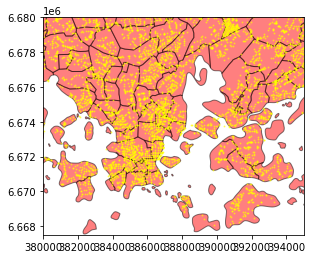

In [3]:
%matplotlib inline
ax = postcode_areas.plot(color='red', edgecolor='black', alpha=0.5)
ax = intersections.plot(ax=ax, color='yellow', markersize=1, alpha=0.5)

# Zoom to closer (comment out the following to see the full extent of the data)
ax.set_xlim([380000, 395000])
ax.set_ylim([6667500, 6680000])

As we can see from the map, we have a large number of points (intersections) that are scattered around the city. 

Next, we want to calculate how many of those points are inside each postal code area visible on the map. For doing this, we are going to take advantage of spatial index.

- Building a spatial index for GeoDataFrame is easy in Geopandas. We can extract that by calling an attribute `.sindex`. 

In [4]:
# Let's build spatial index for intersection points
intersection_sindex = intersections.sindex

# Let's see what it is
intersection_sindex

Okay, as we can see the variable contains a `SpatialIndex` object. Fundamentally, this object contains now the geometries in an R-tree data structure as introduced in the beginning of this page. 

From this spatial index, we can e.g. see, how the geometries have been grouped in the spatial index. 

- Let's see how many groups we have, and extract some basic information from them. We can extract this information using `.leaves()` function.

In [5]:
# How many groups do we have?
print("Number of groups:", len(intersection_sindex.leaves()), '\n')

# Print some basic info for few of them
n_iterations = 10
for i, group in enumerate(intersection_sindex.leaves()):
    group_idx, indices, bbox = group
    print("Group", group_idx, "contains ", len(indices), "geometries, bounding box:", bbox)
    i+=1
    if i == n_iterations:
        break

AttributeError: 'PyGEOSSTRTreeIndex' object has no attribute 'leaves'

We seem to have 908 groups formed in the R-tree, and as we can see, each group seem to consist of 70 geometries. Okay, now as we understand a bit what the `R-tree` index is like. Let's take that into action.

For conducting fast spatial queries, we can utilize the spatial index of the intersections, and compare the geometry of a given postal code area to the **bounding boxes** of points inside the R-tree spatial index. Let's start with a single postal code area, to keep things simple.

<AxesSubplot:>

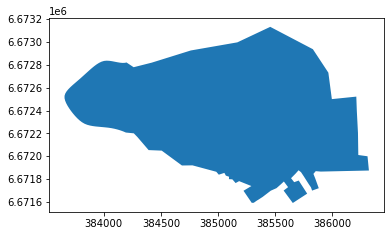

In [6]:
# Select a postal code area representing the city center of Helsinki
city_center_zip_area = postcode_areas.loc[postcode_areas['posti_alue']=='00100']
city_center_zip_area.plot()

 Okay, now we can make a spatial query in which we want to select all the points, that are inside this Polygon. We conduct the point in polygon query in two steps: 
 
 - **first**, we compare the bounds of the Polygon into the spatial index of the Points. This gives us point **candidates** that are likely to be within the Polygon (at this stage based on the MBR of the points that is stored inside the R-tree).
 - **secondly**, we go through the candidate points and make a normal spatial intersection query that gives us the accurate results:

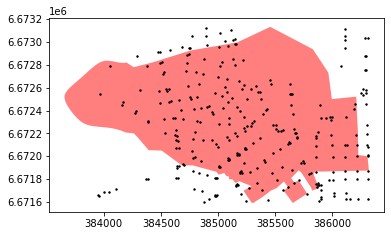

In [7]:
# Get the bounding box coordinates of the Polygon as a list
bounds = list(city_center_zip_area.bounds.values[0])

# Get the indices of the Points that are likely to be inside the bounding box of the given Polygon
point_candidate_idx = list(intersection_sindex.intersection(bounds))
point_candidates = intersections.loc[point_candidate_idx]

# Let's see what we have now
ax = city_center_zip_area.plot(color='red', alpha=0.5)
ax = point_candidates.plot(ax=ax, color='black', markersize=2)

Aha, as we can see, now we have successfully selected such points from the dataset that intersect with the **bounding box** of the Polygon. I.e. we conducted the first step of the process. 

Next, let's do the final selection using a "normal" intersect query, which is however, much faster because there is no need to go through all 63.5 thousand points in the full dataset:

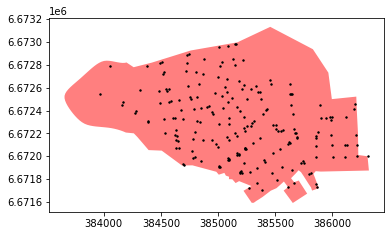

In [8]:
# Make the precise Point in Polygon query
final_selection = point_candidates.loc[point_candidates.intersects(city_center_zip_area['geometry'].values[0])]

# Let's see what we have now
ax = city_center_zip_area.plot(color='red', alpha=0.5)
ax = final_selection.plot(ax=ax, color='black', markersize=2)

### Putting pieces together - Performance comparisons

Following functions both conduct the spatial query that we saw previously, the first one **without** utilizing spatial index and the second one **with** spatial index. We can use them and compare the performance, so that we can get an idea how much the spatial index affects the performance time-wise.

In [9]:
def intersect_using_spatial_index(source_gdf, intersecting_gdf):
    """
    Conduct spatial intersection using spatial index for candidates GeoDataFrame to make queries faster.
    Note, with this function, you can have multiple Polygons in the 'intersecting_gdf' and it will return all the points 
    intersect with ANY of those geometries.
    """
    source_sindex = source_gdf.sindex
    possible_matches_index = []
    
    # 'itertuples()' function is a faster version of 'iterrows()'
    for other in intersecting_gdf.itertuples():
        bounds = other.geometry.bounds
        c = list(source_sindex.intersection(bounds))
        possible_matches_index += c
    
    # Get unique candidates
    unique_candidate_matches = list(set(possible_matches_index))
    possible_matches = source_gdf.iloc[unique_candidate_matches]

    # Conduct the actual intersect
    result = possible_matches.loc[possible_matches.intersects(intersecting_gdf.unary_union)]
    return result

def normal_intersect(source_gdf, intersecting_gdf):
    """
    Conduct spatial intersection without spatial index.
    Note, with this function, you can have multiple Polygons in the 'intersecting_gdf' and it will return all the points 
    intersect with ANY of those geometries.
    """
    
    matches = []
    
    # 'itertuples()' function is a faster version of 'iterrows()'
    for other in intersecting_gdf.itertuples():
        c = list(source_gdf.loc[source_gdf.intersects(other.geometry)].index)
        matches += c
    
    # Get all points that are intersecting with the Polygons
    unique_matches = list(set(matches))
    result = source_gdf.loc[source_gdf.index.isin(unique_matches)]
    return result

- Let's compare their performance and time it. Here we utilize a special IPython magic function called `%timeit` that allows to test how long it takes to run a specific function (it actually runs the function multiple times to get a more representative timing). 

In [10]:
# Test the spatial query with spatial index
%timeit intersect_using_spatial_index(source_gdf=intersections, intersecting_gdf=city_center_zip_area)

23 ms ± 5.65 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [11]:
# Test the spatial query without spatial index
%timeit normal_intersect(source_gdf=intersections, intersecting_gdf=city_center_zip_area)

25.7 ms ± 3.61 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


Okay, as these tests demonstrate, using the spatial index gives a significant boost in the performance, by being around 17x faster. 

Making the spatial query only with a single Polygon (as in the example) might not make a big difference, but having hundreds or thousands of Polygons, and wanting to find all points that are inside those ones, start to make a drastic difference.

### Counting the intersections

The ultimate goal of this tutorial was to count the intersections per postal code. We can do that easily and fast with Geopandas, by conducting a `spatial join` between the two datasets. Spatial join in Geopandas is highly performant, and in fact, it utilizes spatial index to make the queries fast. The following parts might include a bit advanced tricks that we have not covered, but for the sake of completeness, the following steps count the intersections per postal code area. Finally, we plot a density of the intersections as a number of intersections per square kilometer (per postal code area). 

In [12]:
# Count intersections by postal code area
intersection_cnt = gpd.sjoin(postcode_areas, intersections).groupby('posti_alue').size().reset_index()
intersection_cnt.head()

,posti_alue,0
0,00100,203
1,00120,35
2,00130,50
3,00140,44
4,00150,68


In [13]:
# Merge with postcode data and plot
intersection_cnt = intersection_cnt.rename(columns={0: 'intersection_cnt'})
postcode_areas = postcode_areas.merge(intersection_cnt, on='posti_alue')
postcode_areas

,posti_alue,he_vakiy,geometry,intersection_cnt
0,00100,18284.0,"MULTIPOLYGON (((385653.893 6671591.048, 385573...",203
1,00120,7108.0,"MULTIPOLYGON (((385316.092 6671076.984, 385279...",35
2,00130,1508.0,"MULTIPOLYGON (((386212.111 6671061.262, 386176...",50
3,00140,7865.0,"MULTIPOLYGON (((386577.050 6670280.544, 386552...",44
4,00150,9496.0,"MULTIPOLYGON (((384846.102 6669565.816, 384823...",68
...,...,...,...,...
338,25470,279.0,"MULTIPOLYGON (((305067.212 6673543.615, 304620...",16
339,25500,3391.0,"MULTIPOLYGON (((277988.374 6665076.564, 277959...",86
340,25560,208.0,"MULTIPOLYGON (((294139.092 6671931.426, 291442...",48
341,31350,235.0,"MULTIPOLYGON (((329443.822 6726297.286, 329125...",2


<AxesSubplot:>

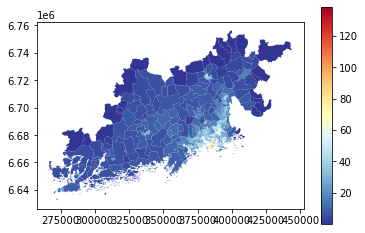

In [14]:
# Plot intersection density (number of intersections per square kilometer inside a Postal code)
m2_to_km2_converter = 1000000
postcode_areas['intersection_density'] = postcode_areas['intersection_cnt'] / (postcode_areas.area / m2_to_km2_converter)
postcode_areas.plot('intersection_density', cmap='RdYlBu_r', legend=True)

From the map, we can see that the intersection density is clearly highest in the city center areas of Helsinki (red colored areas). 

### Note

As we have learned from this tutorial, spatial index can make the spatial queries significantly faster. There is however, a specific situation in which spatial index does not provide any improvements for the performance: if your polygon and points have more or less similar spatial extent (bounding box), the spatial index does not help to make the queries faster due to its design in working on a level of bounding boxes. This happens e.g. in following case:

![los-angeles-boundary-intersections.png](img/los-angeles-boundary-intersections.png)
*Example of a situation where spatial index does not provide boost in performance* (Source: [G. Boeing, 2016](https://geoffboeing.com/2016/10/r-tree-spatial-index-python/))

As we can see, in the map, there is a complex Polygon that share more or less identical extent as the point layer, which is problematic from performance point of view.

There is, however, a nice strategy to deal with this kind of situation, by sub-dividing the Polygon into smaller subsets (having also smaller bounding boxes) that will enable the spatial index to boost the queries:

![los-angeles-boundary-quadrats-intersections](img/los-angeles-boundary-quadrats-intersections.png).

You can read more about this strategy from an excellent post from [G. Boeing](https://geoffboeing.com/2016/10/r-tree-spatial-index-python/).